# Sensitivity Analysis

In [2]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from project import preprocessing, rf_models, mc_experiments

## Sensitivity Analysis of Initial Classification

In [5]:
df_ic = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

In [6]:
df_ic = preprocessing.preprocess_input_vars(df_ic)
data_ic = df_ic[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "control_number"
    ]
]
data_ic = data_ic[data_ic["ic_custdy_level"] > 1]
data_ic = data_ic.dropna()

In [7]:
X = data_ic.drop(["control_number", "ic_custdy_level"], axis=1)
Y = data_ic["ic_custdy_level"]

In [8]:
ic_rf_model = rf_models.BasicRFModel(X, Y)
ic_rf_model.fit()

In [9]:
ic_sen = mc_experiments.sensitivity_analysis(
    df=data_ic,
    perturb_vars=[
        "off_1_prs_max",
        "off_1_gs_max",
        "prior_commits",
        "ic_institut_adj"
    ],
    rf=ic_rf_model,
    drop_vars=[
        "ic_custdy_level",
        "control_number"
    ]
)

In [10]:
ic_sen

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,control_number,original_pred,off_1_prs_max_up_pred,off_1_prs_max_down_pred,off_1_gs_max_up_pred,off_1_gs_max_down_pred,prior_commits_up_pred,prior_commits_down_pred,ic_institut_adj_up_pred,ic_institut_adj_down_pred
20,0,0,0,1,0,0,0,0,4.0,15.0,...,8100,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
31,0,1,0,1,0,0,0,0,4.0,14.0,...,11689,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0
33,0,0,0,1,0,0,0,0,3.0,14.0,...,11990,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
34,0,1,0,0,0,0,0,0,4.0,15.0,...,13170,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
36,0,1,0,0,0,0,0,0,4.0,14.0,...,13586,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59538,0,1,0,1,0,0,0,0,4.0,6.0,...,351514,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
59542,0,1,0,0,0,0,0,0,0.5,5.0,...,351647,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
59544,0,0,0,0,0,0,0,0,2.0,9.0,...,351659,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
59549,0,1,0,1,0,0,0,0,3.0,5.0,...,351762,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [11]:
ic_sen.groupby(["ic_custdy_level"])["off_1_prs_max_up_pred"].mean()

ic_custdy_level
2.0    2.135196
3.0    3.052310
4.0    3.956098
5.0    4.607843
Name: off_1_prs_max_up_pred, dtype: float64

In [12]:
ic_sen.groupby(["ic_custdy_level"])["off_1_prs_max_down_pred"].mean()

ic_custdy_level
2.0    2.132931
3.0    3.051466
4.0    3.956228
5.0    4.607843
Name: off_1_prs_max_down_pred, dtype: float64

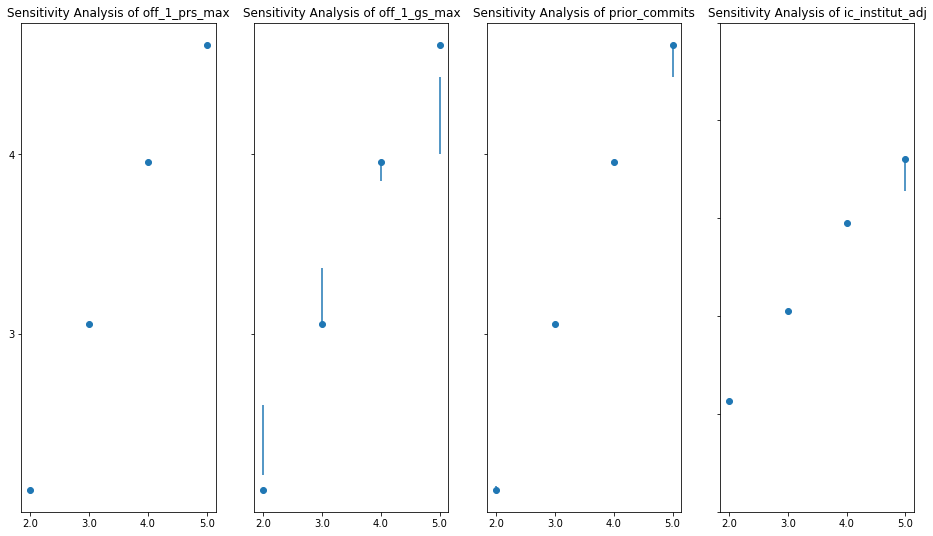

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
original_pred_means = ic_sen.groupby("ic_custdy_level")["original_pred"].mean()
for i, var in enumerate(["off_1_prs_max", "off_1_gs_max", "prior_commits", "ic_institut_adj"]):
    xs = np.arange(1, 5)
    ax[i].errorbar(
        xs,
        original_pred_means,
        yerr=[
            (original_pred_means - ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean()),
            (ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean() - original_pred_means)
        ],
        fmt="o"
    )
    # ax[i].plot(
    #     xs,
    #     original_pred_means,
    #     c="green"
    # )
    # # ax[i].axline()
    # ax[i].scatter(
    #     xs,
    #     ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean(),
    #     c="blue"
    # )
    # ax[i].scatter(
    #     xs,
    #     ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean(),
    #     c="red"
    # )
    ax[i].set_xticks(xs)
    ax[i].set_xticklabels(sorted(ic_sen["ic_custdy_level"].unique()))
    ax[i].set_yticks(np.arange(1, 7))
    ax[i].set_title(f"Sensitivity Analysis of {var}")
        

ic_custdy_level
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
dtype: float64
ic_custdy_level
2.0   -0.106232
3.0   -0.027649
4.0    0.003283
5.0    0.000000
dtype: float64
ic_custdy_level
2.0    -3.859773
3.0     0.103684
4.0     2.656029
5.0    13.191489
dtype: float64
ic_custdy_level
2.0   -22.131728
3.0   -10.299302
4.0    -0.170721
5.0     3.829787
dtype: float64
ic_custdy_level
2.0   -0.849858
3.0   -0.359439
4.0    0.196986
5.0    3.829787
dtype: float64
ic_custdy_level
2.0   -0.743626
3.0   -0.138246
4.0    0.098493
5.0    0.425532
dtype: float64
ic_custdy_level
2.0   -0.389518
3.0   -0.082947
4.0    0.226534
5.0    7.234043
dtype: float64
ic_custdy_level
2.0   -0.035411
3.0    0.000000
4.0   -0.003283
5.0    0.000000
dtype: float64


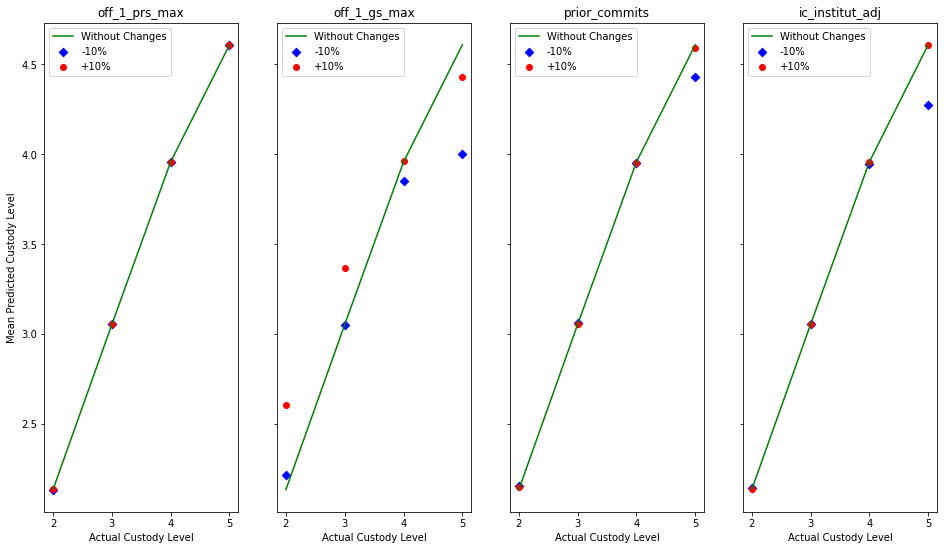

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
original_pred_means = ic_sen.groupby("ic_custdy_level")["original_pred"].mean()
for i, var in enumerate(["off_1_prs_max", "off_1_gs_max", "prior_commits", "ic_institut_adj"]):
    xs = np.arange(2, 6)
    ax[i].plot(
        xs,
        original_pred_means,
        c="green",
        label="Without Changes"
    )
    # ax[i].axline()
    ax[i].scatter(
        xs,
        ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean(),
        c="blue",
        marker="D",
        label="-10%"
    )
    ax[i].scatter(
        xs,
        ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean(),
        c="red",
        label="+10%"
    )
    ax[i].set_title(f"{var}")
    ax[i].legend(loc="upper left")
    if i == 0:
        ax[i].set_ylabel("Mean Predicted Custody Level")
    ax[i].set_xlabel("Actual Custody Level")
    down_mean = ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean()
    up_mean = ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean()
    print(100*(original_pred_means - down_mean)/original_pred_means)
    print(100*(original_pred_means - up_mean)/original_pred_means)# print the relative change

In [23]:
original_pred_means, down_mean, original_pred_means-down_mean, (original_pred_means-down_mean)/original_pred_means

(ic_custdy_level
 2.0    2.132931
 3.0    3.051466
 4.0    3.956228
 5.0    4.607843
 Name: original_pred, dtype: float64,
 ic_custdy_level
 2.0    2.141239
 3.0    3.053997
 4.0    3.947266
 5.0    4.274510
 Name: ic_institut_adj_down_pred, dtype: float64,
 ic_custdy_level
 2.0   -0.008308
 3.0   -0.002531
 4.0    0.008962
 5.0    0.333333
 dtype: float64,
 ic_custdy_level
 2.0   -0.003895
 3.0   -0.000829
 4.0    0.002265
 5.0    0.072340
 dtype: float64)

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,control_number,original_pred,off_1_prs_max_up_pred,off_1_prs_max_down_pred,off_1_gs_max_up_pred,off_1_gs_max_down_pred,prior_commits_up_pred,prior_commits_down_pred,ic_institut_adj_up_pred,ic_institut_adj_down_pred
20,0,0,0,1,0,0,0,0,4.0,15.0,...,8100,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
31,0,1,0,1,0,0,0,0,4.0,14.0,...,11689,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0
33,0,0,0,1,0,0,0,0,3.0,14.0,...,11990,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
34,0,1,0,0,0,0,0,0,4.0,15.0,...,13170,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
36,0,1,0,0,0,0,0,0,4.0,14.0,...,13586,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59538,0,1,0,1,0,0,0,0,4.0,6.0,...,351514,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
59542,0,1,0,0,0,0,0,0,0.5,5.0,...,351647,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
59544,0,0,0,0,0,0,0,0,2.0,9.0,...,351659,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
59549,0,1,0,1,0,0,0,0,3.0,5.0,...,351762,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
ic_sen.groupby(["ic_custdy_level"])["off_1_prs_max_up_pred"].mean()

ic_custdy_level
2.0    2.144260
3.0    3.051466
4.0    3.956358
5.0    4.627451
Name: off_1_prs_max_up_pred, dtype: float64

In [11]:
ic_sen.groupby(["ic_custdy_level"])["off_1_prs_max_down_pred"].mean()

ic_custdy_level
2.0    2.142749
3.0    3.051044
4.0    3.956488
5.0    4.627451
Name: off_1_prs_max_down_pred, dtype: float64

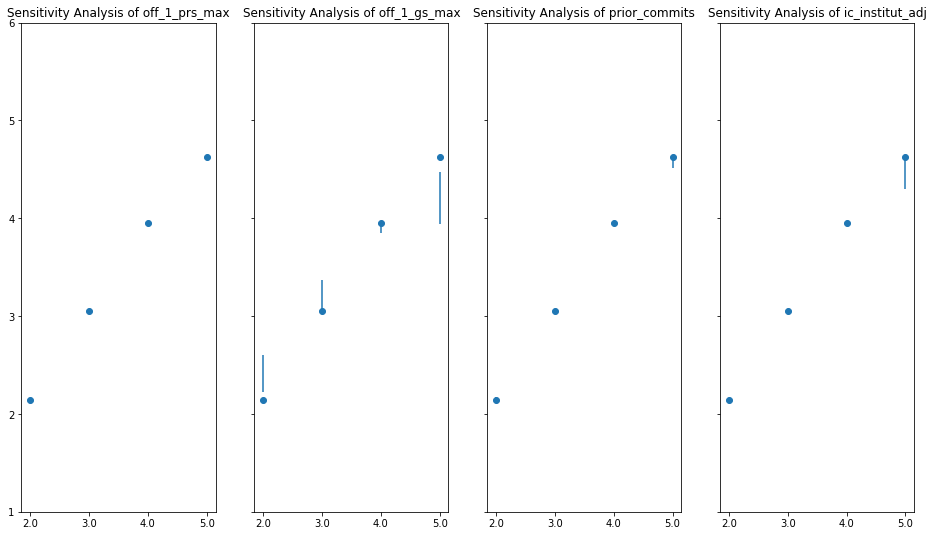

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
original_pred_means = ic_sen.groupby("ic_custdy_level")["original_pred"].mean()
for i, var in enumerate(["off_1_prs_max", "off_1_gs_max", "prior_commits", "ic_institut_adj"]):
    xs = np.arange(1, 5)
    ax[i].errorbar(
        xs,
        original_pred_means,
        yerr=[
            (original_pred_means - ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean()),
            (ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean() - original_pred_means)
        ],
        fmt="o"
    )
    # ax[i].plot(
    #     xs,
    #     original_pred_means,
    #     c="green"
    # )
    # # ax[i].axline()
    # ax[i].scatter(
    #     xs,
    #     ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean(),
    #     c="blue"
    # )
    # ax[i].scatter(
    #     xs,
    #     ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean(),
    #     c="red"
    # )
    ax[i].set_xticks(xs)
    ax[i].set_xticklabels(sorted(ic_sen["ic_custdy_level"].unique()))
    ax[i].set_yticks(np.arange(1, 7))
    ax[i].set_title(f"Sensitivity Analysis of {var}")
        

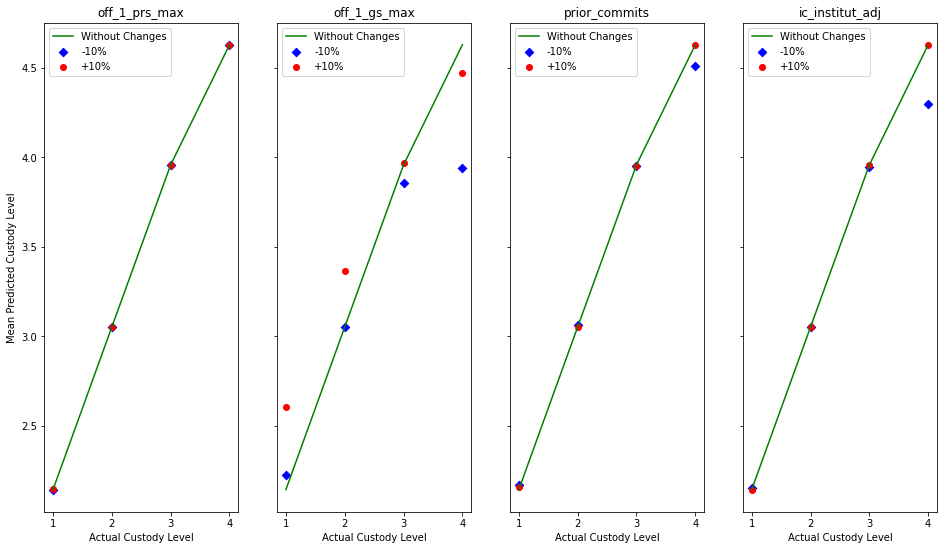

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
original_pred_means = ic_sen.groupby("ic_custdy_level")["original_pred"].mean()
for i, var in enumerate(["off_1_prs_max", "off_1_gs_max", "prior_commits", "ic_institut_adj"]):
    xs = np.arange(1, 5)
    ax[i].plot(
        xs,
        original_pred_means,
        c="green",
        label="Without Changes"
    )
    # ax[i].axline()
    ax[i].scatter(
        xs,
        ic_sen.groupby(["ic_custdy_level"])[f"{var}_down_pred"].mean(),
        c="blue",
        marker="D",
        label="-10%"
    )
    ax[i].scatter(
        xs,
        ic_sen.groupby(["ic_custdy_level"])[f"{var}_up_pred"].mean(),
        c="red",
        label="+10%"
    )
    ax[i].set_title(f"{var}")
    ax[i].legend(loc="upper left")
    if i == 0:
        ax[i].set_ylabel("Mean Predicted Custody Level")
    ax[i].set_xlabel("Actual Custody Level")
fig.savefig("../paper/images/ic_sa.png")

## Sensitivity Analysis of Reclassification

In [14]:
df_re = pd.read_csv("../data/re_custody_2017_gsprs.csv", low_memory=False)

In [15]:
df_re = preprocessing.preprocess_input_vars_re(df_re)
data_re = df_re[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "re_custody_level",
        "ic_custdy_level",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        "re_escp_hist_2",
        "re_escp_hist_3",
        "re_escp_hist_4",
        "re_escp_hist_5",
        "control_number"
    ]
]
data_re = data_re[data_re["re_custody_level"] > 1]
data_re = data_re.dropna()

In [16]:
X = data_re.drop(["control_number", "re_custody_level"], axis=1)
Y = data_re["re_custody_level"]

In [17]:
re_rf_model = rf_models.BasicRFModel(X, Y)
re_rf_model.fit()

In [18]:
re_sen = mc_experiments.sensitivity_analysis(
    df=data_re,
    perturb_vars=[
        "off_1_prs_max",
        "off_1_gs_max",
        "prior_commits",
        "re_discip_reports",
        "ic_custdy_level"
    ],
    rf=re_rf_model,
    drop_vars=[
        "re_custody_level",
        "control_number"
    ]
)

In [19]:
re_sen.off_1_gs_max

2         8.0
3        15.0
20       15.0
31       14.0
33       14.0
         ... 
59368     9.0
59382    12.0
59385    14.0
59398     8.0
59499     5.0
Name: off_1_gs_max, Length: 14573, dtype: float64

In [20]:
data_re.off_1_gs_max

2         8.0
3        15.0
20       15.0
31       14.0
33       14.0
         ... 
59368     9.0
59382    12.0
59385    14.0
59398     8.0
59499     5.0
Name: off_1_gs_max, Length: 14573, dtype: float64

In [21]:
re_sen.groupby("re_custody_level").off_1_gs_max_up_pred.value_counts()

re_custody_level  off_1_gs_max_up_pred
2.0               2.0                     8400
                  3.0                      338
                  5.0                       17
                  4.0                       11
3.0               3.0                     2513
                  2.0                      416
                  4.0                      284
                  5.0                       47
4.0               4.0                     1337
                  3.0                      344
                  5.0                       71
                  2.0                       32
5.0               5.0                      348
                  4.0                      169
                  3.0                      158
                  2.0                       88
Name: off_1_gs_max_up_pred, dtype: int64

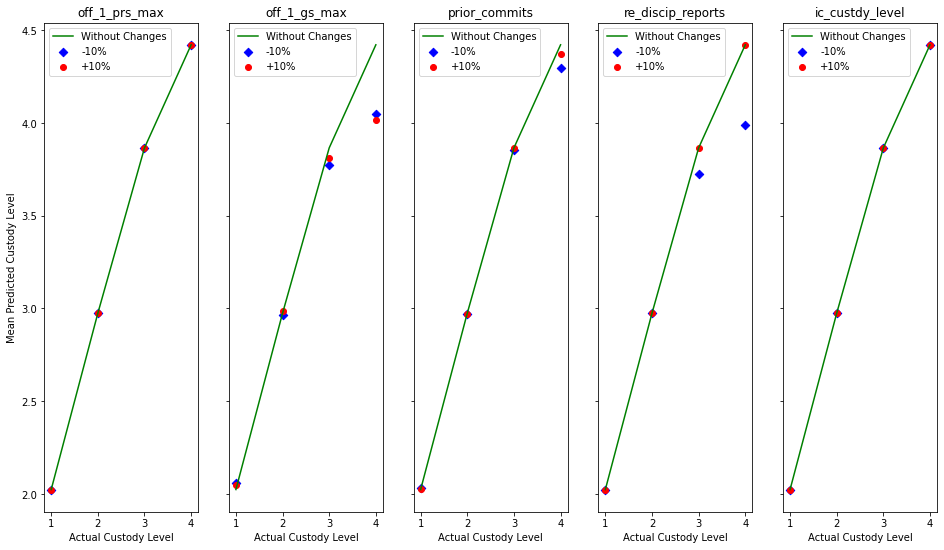

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(16, 9), sharey=True)
original_pred_means = re_sen.groupby("re_custody_level")["original_pred"].mean()
for i, var in enumerate([ "off_1_prs_max", "off_1_gs_max", "prior_commits", "re_discip_reports", "ic_custdy_level" ]):
    xs = np.arange(1, 5)
    ax[i].plot(
        xs,
        original_pred_means,
        c="green",
        label="Without Changes"
    )
    # ax[i].axline()
    ax[i].scatter(
        xs,
        re_sen.groupby(["re_custody_level"])[f"{var}_down_pred"].mean(),
        c="blue",
        marker="D",
        label="-10%"
    )
    ax[i].scatter(
        xs,
        re_sen.groupby(["re_custody_level"])[f"{var}_up_pred"].mean(),
        c="red",
        label="+10%"
    )
    ax[i].set_title(f"{var}")
    ax[i].legend(loc="upper left")
    if i == 0:
        ax[i].set_ylabel("Mean Predicted Custody Level")
    ax[i].set_xlabel("Actual Custody Level")